In [7]:
import csv
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
### Settings
HOME_PATH = "/content"              # Location of the working directory
DATASET_PATH = "dataset/demo"   # Upload your .csv samples to this directory
OUT_PATH = "/content/out"           # Where output files go (will be deleted and recreated)
OUT_ZIP = "/content/out.zip"        # Where to store the zipped output files

# Do not change these settings!
PREP_DROP = -1                      # Drop a column
PREP_NONE = 0                       # Perform no preprocessing on column of data
PREP_STD = 1                        # Perform standardization on column of data
PREP_NORM = 2                       # Perform normalization on column of data

In [9]:
import os
print("Working directory:", os.getcwd())

Working directory: c:\Users\juand\ml lab\mini proect


In [10]:
# Store header, raw data, and number of lines found in each .csv file
header = None
raw_data = []
num_lines = []
filenames = []

# Read each CSV file
for filename in os.listdir(DATASET_PATH):
    filepath = os.path.join(DATASET_PATH, filename)
    if not os.path.isfile(filepath):
        continue

    with open(filepath) as f:
        csv_reader = csv.reader(f, delimiter=',')

        valid_line_counter = 0
        for line_count, line in enumerate(csv_reader):
            if line_count == 0:
                try:
                    # Try converting values to float — if it works, it's not a header
                    [float(val) for val in line]
                    is_data = True
                except ValueError:
                    is_data = False

                if not is_data:
                    # Normalize this actual header
                    normalized_line = [h.strip().lower() for h in line]
                    if header is None:
                        header = normalized_line
                    if normalized_line == header:
                        num_lines.append(0)
                        filenames.append(filename)
                        continue
                    else:
                        print(f"Error: Headers do not match in file '{filename}'. Skipping.")
                        print("Expected:", header)
                        print("Found:   ", normalized_line)
                        break
                else:
                    # First line is actually data (no header in file)
                    if header is None:
                        print(f"Error: No header found before data in file '{filename}'. Skipping.")
                        break
                    elif len(line) == len(header):
                        raw_data.append(line)
                        num_lines.append(1)
                        filenames.append(filename)
                    else:
                        print(f"Error: Data length does not match expected header length in file '{filename}'. Skipping.")
                        break
            else:
                if len(line) == len(header):
                    raw_data.append(line)
                    num_lines[-1] += 1
                else:
                    print(f"Error: Line length does not match header in file '{filename}'. Skipping line.")
                    continue

# Convert raw data to numpy array
raw_data = np.array(raw_data).astype(float)

# Print summary
print("Dataset array shape:", raw_data.shape)
print("Number of elements in num_lines:", len(num_lines))
print("Number of filenames:", len(filenames))
assert(len(num_lines) == len(filenames))

Error: No header found before data in file 'CIEbackground.1745490783239.csv'. Skipping.
Dataset array shape: (3540, 10)
Number of elements in num_lines: 445
Number of filenames: 445


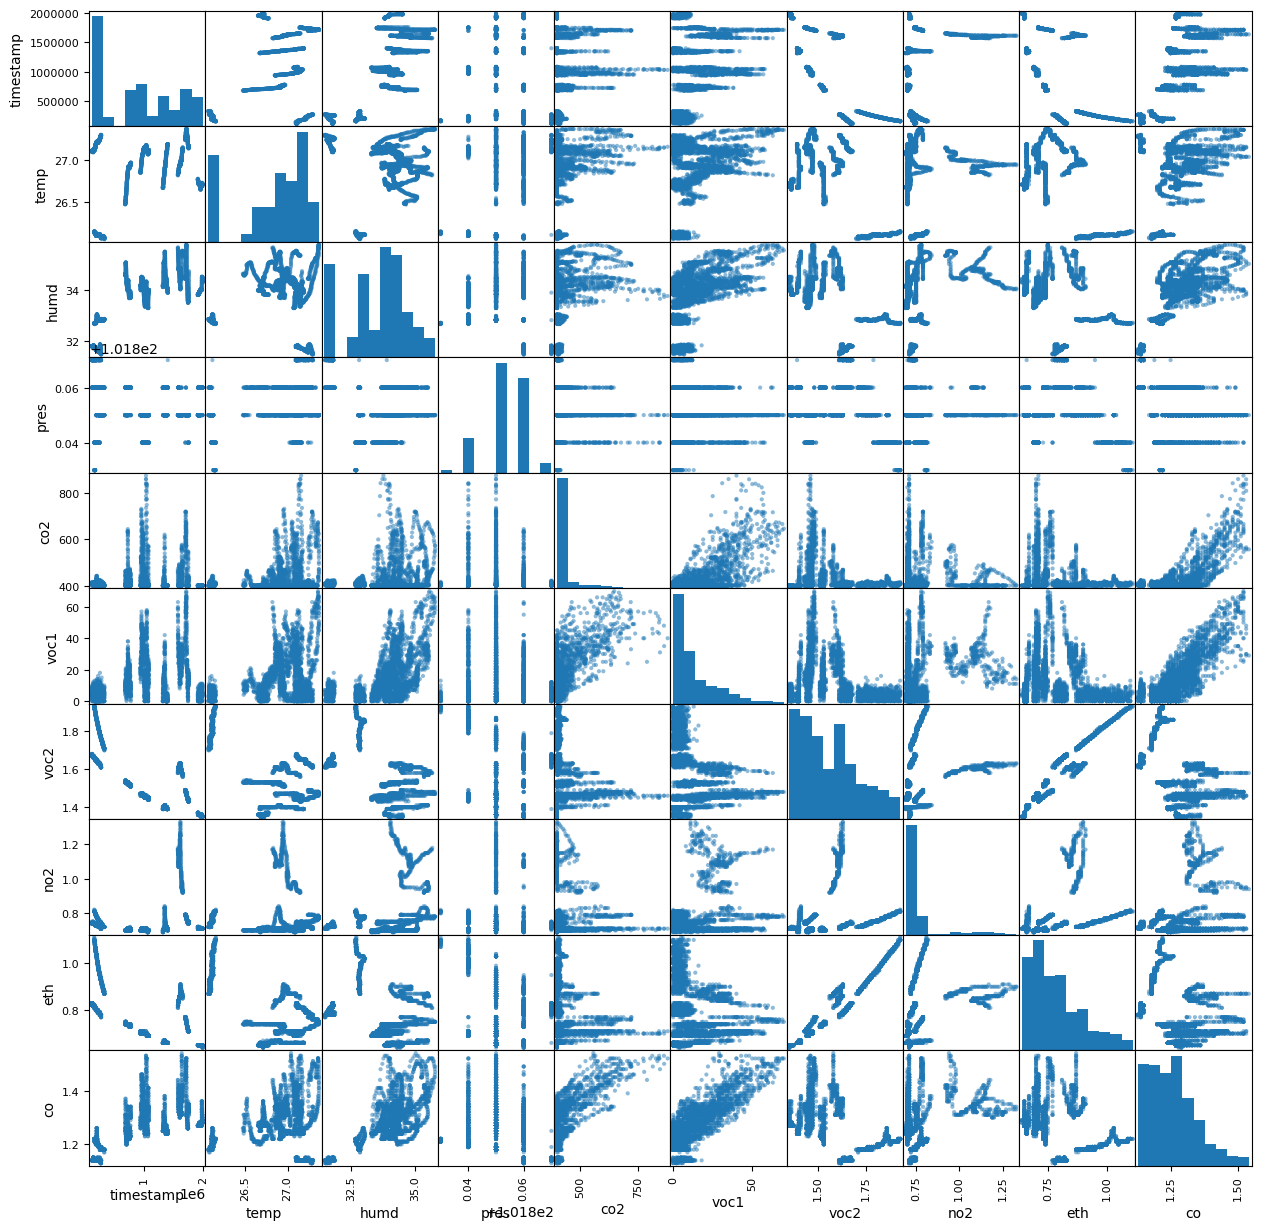

In [11]:
### Plot scatter matrix to look for correlation

# Convert NumPy array to Pandas DataFrame
df = pd.DataFrame(raw_data, columns=header)

# Create scatter matrix
sm = pd.plotting.scatter_matrix(df, figsize=(15, 15))

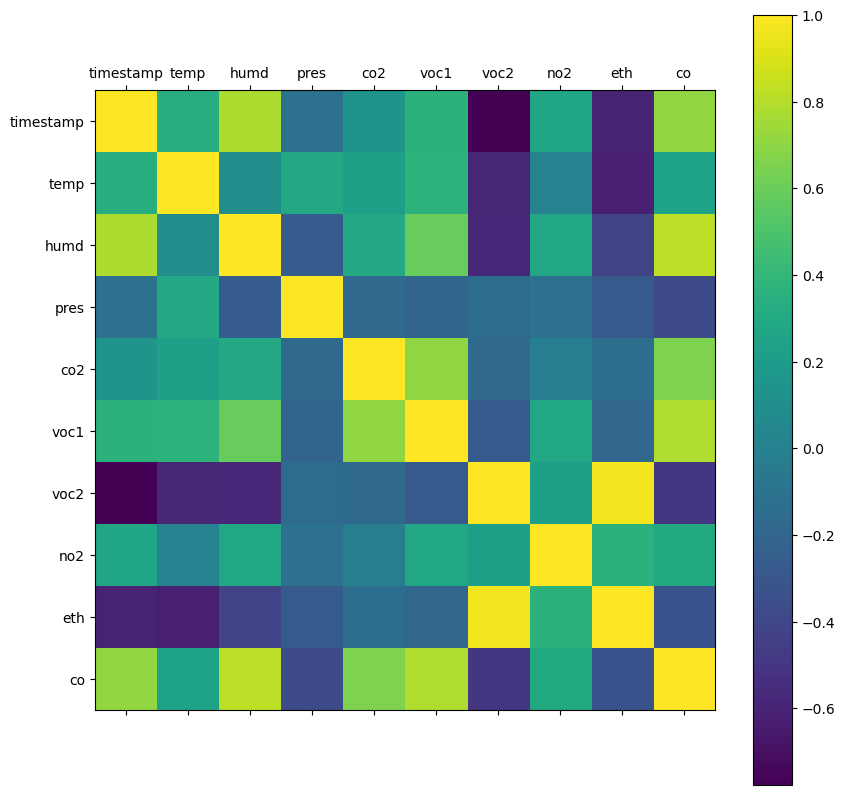

In [12]:
### Show correlation matrix as colors

# Create plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(df.corr())

# Add legend
fig.colorbar(im)

# Add x and y labels
_ = ax.set_xticks(np.arange(len(header)))
_ = ax.set_xticklabels(header)
_ = ax.set_yticks(np.arange(len(header)))
_ = ax.set_yticklabels(header)

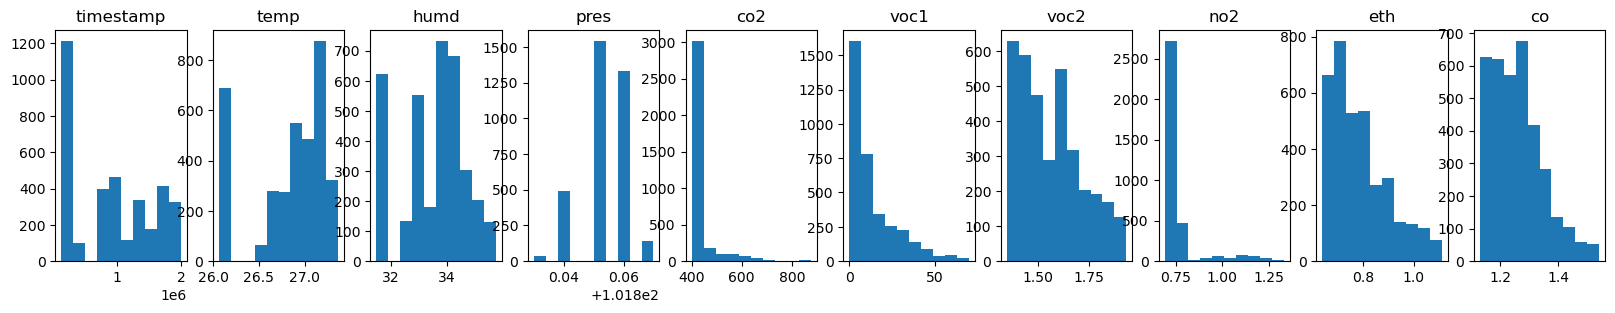

In [13]:
### Examine the histograms of all the data

# Create subplots
num_hists = len(header)
fig, axs = plt.subplots(1, num_hists, figsize=(20,3))

# Create histogram for each category of data
for i in range(num_hists):
  _ = axs[i].hist(raw_data[:, i])
  axs[i].title.set_text(header[i])

In [14]:
### Analyze the data

# Calculate means, standard deviations, and ranges
means = np.mean(raw_data, axis=0)
std_devs = np.std(raw_data, axis=0)
maxes = np.max(raw_data, axis=0)
mins = np.min(raw_data, axis=0)
ranges = np.ptp(raw_data, axis=0)

# Print results
for i, name in enumerate(header):
  print(name)
  print("  mean:", means[i])
  print("  std dev:", std_devs[i])
  print("  max:", maxes[i])
  print("  min:", mins[i])
  print("  range:", ranges[i])

timestamp
  mean: 916407.4790960453
  std dev: 628785.2419285426
  max: 1990054.0
  min: 120515.0
  range: 1869539.0
temp
  mean: 26.833957627118835
  std dev: 0.40258201032919544
  max: 27.37
  min: 26.06
  range: 1.3100000000000023
humd
  mean: 33.54030790960451
  std dev: 1.1008837441737538
  max: 35.76
  min: 31.48
  range: 4.279999999999998
pres
  mean: 101.85298022598218
  std dev: 0.0079058480789373
  max: 101.87
  min: 101.83
  range: 0.04000000000000625
co2
  mean: 427.48446327683615
  std dev: 62.98908107665574
  max: 877.0
  min: 400.0
  range: 477.0
voc1
  mean: 13.061581920903954
  std dev: 13.77636737541862
  max: 70.0
  min: 0.0
  range: 70.0
voc2
  mean: 1.5642740112994236
  std dev: 0.15117994872074886
  max: 1.93
  min: 1.35
  range: 0.5799999999999998
no2
  mean: 0.7611610169491677
  std dev: 0.1118917053876609
  max: 1.33
  min: 0.69
  range: 0.6400000000000001
eth
  mean: 0.7841440677966284
  std dev: 0.11369911045846691
  max: 1.11
  min: 0.64
  range: 0.470000000

In [ ]:
#Choosing the preprocessing method for each data type.
preproc = [PREP_DROP,   # Timestamp, this will not be used when training the model
           PREP_NORM,   # Temperature
           PREP_NORM,   # Humidity
           PREP_DROP,   # Pressure, this remains consistent throughout all tests
           PREP_NORM,   # CO2
           PREP_NORM,   # VOC1
           PREP_NORM,   # VOC2
           PREP_NORM,   # NO2
           PREP_NORM,   # Ethanol
           PREP_NORM]   # CO
#the rest are normalization since there is no Gaussian distribution

# Check to make sure we have the correct number of preprocessing request elements
assert(len(preproc) == len(header))
assert(len(preproc) == raw_data.shape[1])

In [16]:
### Perform preprocessing steps as requested

# Figure out how many columns we plan to keep
num_cols = sum(1 for x in preproc if x != PREP_DROP)

# Create empty numpy array and header for preprocessed data
prep_data = np.zeros((raw_data.shape[0], num_cols))
prep_header = []
prep_means = []
prep_std_devs = []
prep_mins = []
prep_ranges = []

# Go through each column to preprocess the data
prep_c = 0
for raw_c in range(len(header)):

  # Drop column if requested
  if preproc[raw_c] == PREP_DROP:
    print("Dropping", header[raw_c])
    continue

  # Perform data standardization
  if preproc[raw_c] == PREP_STD:
    prep_data[:, prep_c] = (raw_data[:, raw_c] - means[raw_c]) / std_devs[raw_c]

  # Perform data normalization
  elif preproc[raw_c] == PREP_NORM:
    prep_data[:, prep_c] = (raw_data[:, raw_c] - mins[raw_c]) / ranges[raw_c]

  # Copy data over if no preprocessing is requested
  elif preproc[raw_c] == PREP_NONE:
    prep_data[:, raw_c] = raw_data[:, raw_c]

  # Error if code not recognized
  else:
    raise Exception("Preprocessing code not recognized")

  # Copy header (and preprocessing constants) and increment preprocessing column index
  prep_header.append(header[raw_c])
  prep_means.append(means[raw_c])
  prep_std_devs.append(std_devs[raw_c])
  prep_mins.append(mins[raw_c])
  prep_ranges.append(ranges[raw_c])
  prep_c += 1

# Show new data header and shape
print(prep_header)
print("New data shape:", prep_data.shape)
print("Means:", [float("{:.4f}".format(x)) for x in prep_means])
print("Std devs:", [float("{:.4f}".format(x)) for x in prep_std_devs])
print("Mins:", [float("{:.4f}".format(x)) for x in prep_mins])
print("Ranges:", [float("{:.4f}".format(x)) for x in prep_ranges])

Dropping timestamp
Dropping pres
['temp', 'humd', 'co2', 'voc1', 'voc2', 'no2', 'eth', 'co']
New data shape: (3540, 8)
Means: [26.834, 33.5403, 427.4845, 13.0616, 1.5643, 0.7612, 0.7841, 1.2573]
Std devs: [0.4026, 1.1009, 62.9891, 13.7764, 0.1512, 0.1119, 0.1137, 0.0888]
Mins: [26.06, 31.48, 400.0, 0.0, 1.35, 0.69, 0.64, 1.13]
Ranges: [1.31, 4.28, 477.0, 70.0, 0.58, 0.64, 0.47, 0.41]


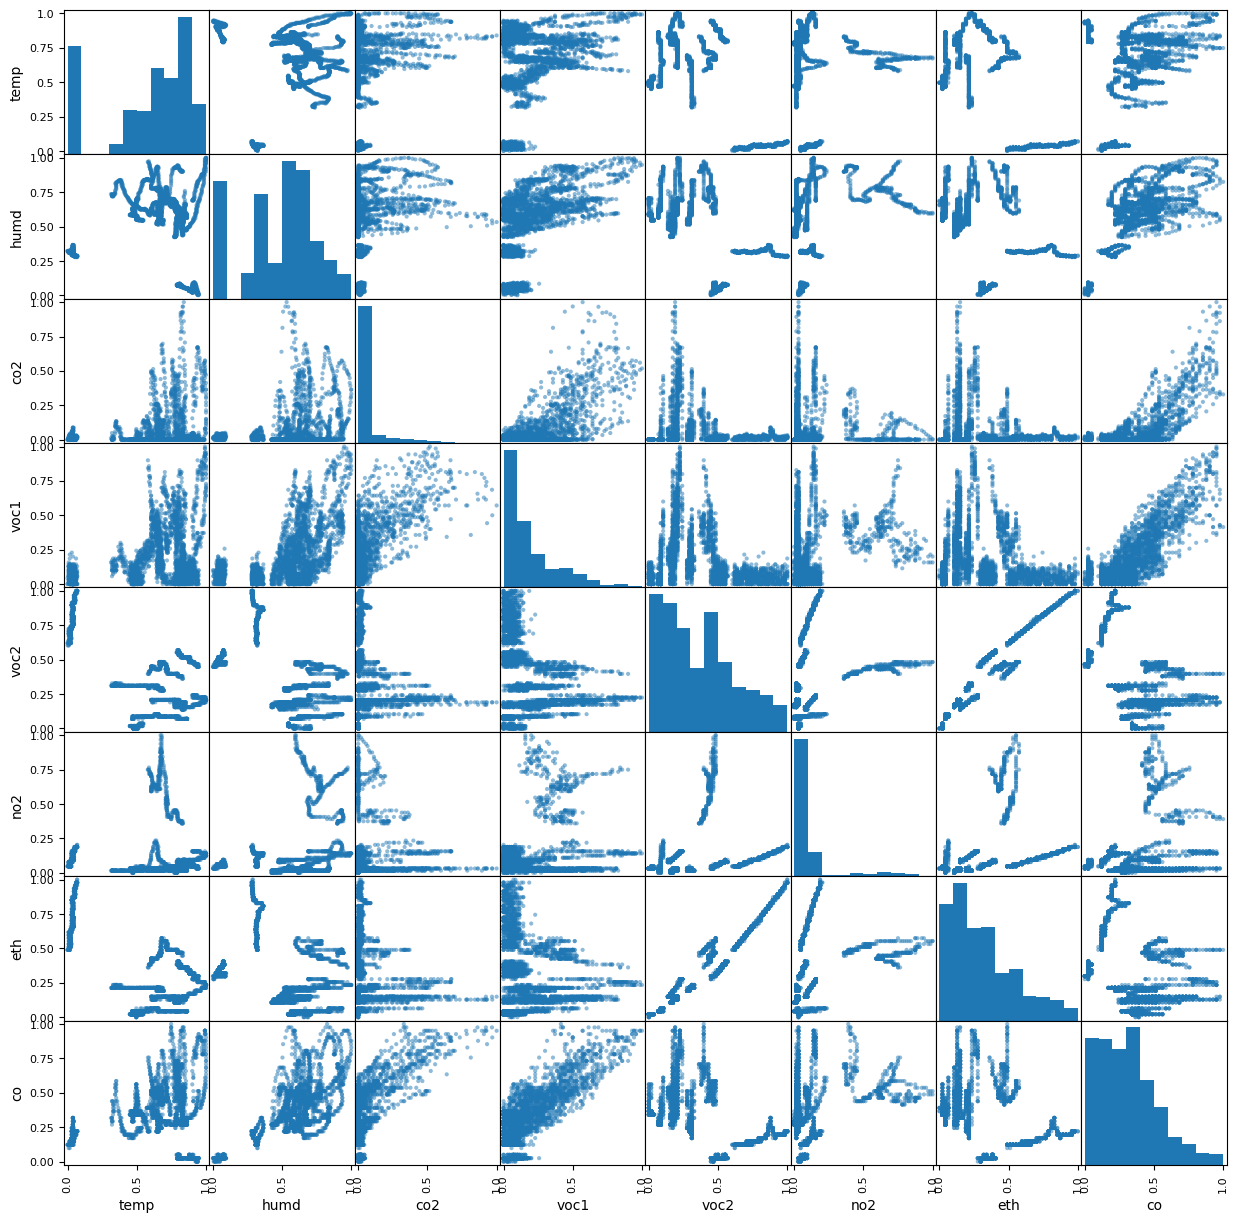

In [17]:
### Recreate the scatter matrix to look for correlation

# Convert NumPy array to Pandas DataFrame
df = pd.DataFrame(prep_data, columns=prep_header)

# Create scatter matrix
sm = pd.plotting.scatter_matrix(df, figsize=(15, 15))

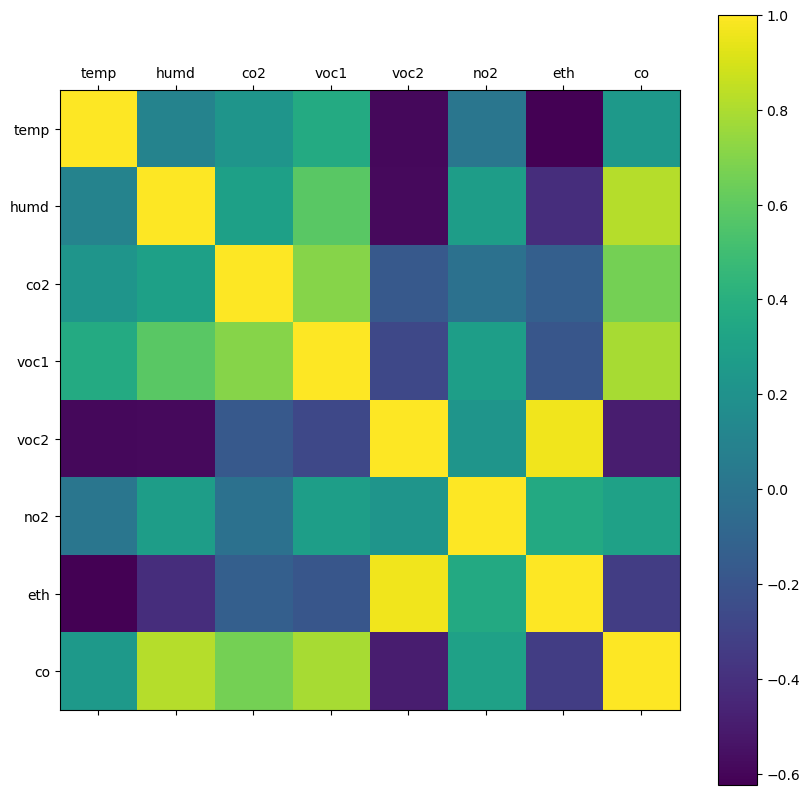

In [18]:
### Show correlation matrix as colors

# Create plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(df.corr())

# Add legend
fig.colorbar(im)

# Add x and y labels
_ = ax.set_xticks(np.arange(len(prep_header)))
_ = ax.set_xticklabels(prep_header)
_ = ax.set_yticks(np.arange(len(prep_header)))
_ = ax.set_yticklabels(prep_header)

In [19]:
### Delete output directory (if it exists) and recreate it
if os.path.exists(OUT_PATH):
  shutil.rmtree(OUT_PATH)
os.makedirs(OUT_PATH)

In [20]:
### Write out data to .csv files

# Go through all the original filenames
row_index = 0
for file_num, filename in enumerate(filenames):

  # Open .csv file
  file_path = os.path.join(OUT_PATH, filename)
  with open(file_path, 'w') as f:
    csv_writer = csv.writer(f, delimiter=',')

    # Write header
    csv_writer.writerow(prep_header)

    # Write contents
    for _ in range(num_lines[file_num]):
      csv_writer.writerow(prep_data[row_index])
      row_index += 1

In [21]:
### Zip output directory
%cd {OUT_PATH}
!zip -FS -r -q {OUT_ZIP} *
%cd {HOME_PATH}

c:\content\out


c:\Users\juand\anaconda3\envs\ML\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


c:\content


'zip' is not recognized as an internal or external command,
operable program or batch file.
